In [13]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")

emcee_Run

# 2-Parameter Elliptic Equation
Consider the one-dimensional elliptic boundary-value problem

$$
    -\frac{d}{dx}\Big(\exp(\theta_{(1)}) \frac{d}{dx}p(x)\Big) = 1, \qquad x\in[0,1]
$$

with boundary conditions $p(0) = 0$ and $p(1) = \theta_{(2)}$. The solution for this problem is given by  

$$
    p(x) = \theta_{(2)} x + \exp(-\theta_{(1)})\Big(-\frac{x^2}{2} + \frac{x}{2}\Big).
$$

The inverse problem is to solve for $\theta = (\theta_{(1)},\, \theta_{(2)})^T$ with the observations $y = (p(x_1),\,p(x_2))^T$ at $x_1=0.25$ and $x_2=0.75$.
The Bayesian inverse problem is formulated as 

$$
    y = \mathcal{G}(\theta) + \eta \qquad \textrm{and} \qquad 
    \mathcal{G}(\theta) = \begin{bmatrix}
    p(x_1, \theta)\\
    p(x_2, \theta)
    \end{bmatrix},
$$
here $\mathcal{G}(\theta)$ is the forward model operator.   The observation is $y=(27.5, 79.7)^T$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. And the prior is $\mathcal{N}(0, 10^2 I)$, which is almost uninformative.

The numerical experiment considered here is a counterexample against the ensemble Kalman filter, which is proposed in [1] and further used in [2,3]. 

1. Ernst, Oliver G and Sprungk, Björn and Starkloff, Hans-Jörg, "Analysis of the ensemble and polynomial chaos Kalman filters in Bayesian inverse problems"

2. Herty, Michael and Visconti, Giuseppe, "Kinetic methods for inverse problems"

3. Garbuno-Inigo, Alfredo and Hoffmann, Franca and Li, Wuchen and Stuart, Andrew M, "Interacting Langevin diffusions: Gradient structure and ensemble Kalman sampler


In [14]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function forward(s_param, θ::Array{Float64,1})
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; p(x2)]
end


function forward_illposed(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ;]
end


function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 6 methods)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* UKI method: initialized at $\theta_0\sim\mathcal{N}(-1, 0.5^2)$  

In [48]:
function Ellitic_Posterior_Plot(problem_type = "under-determined",  μ0::Array{Float64, 1} = [0.0; 100.0], Σ0::Array{Float64, 2}=[1.0^2  0.0; 0.0 1.0^2], Nt = 30, N_ens = 100, file_name = "")
    
    @info "start Ellitic_Posterior_Plot"
    Random.seed!(123)
    N_θ = 2
    FT = Float64
    # observation and observation error covariance
    if problem_type == "under-determined"
        y = [27.5;]
        Σ_η = fill(0.1^2, (1,1))
        forward_func = forward_illposed
    else
        y = [27.5; 79.7]
        Σ_η = Array(Diagonal(fill(0.1^2, 2)))
        forward_func = forward
    end
    
    N_y = length(y)
    s_param = Setup_Param(N_θ, N_y)
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward_func, y, Σ_η, μ0, Σ0)
    step_length = 1.0
    N_iter_MCMC , n_burn_in= 5000000, 1000000
    
    # N_iter_MCMC , n_burn_in= 50, 10

    
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter_MCMC)
    θ_post = (sum(us[n_burn_in:end, :], dims = 1)/size(us[n_burn_in:end, :], 1))'
    Σ_post = zeros(Float64, N_θ, N_θ)
    for i = 1:N_θ
        for j = 1:N_θ
            Σ_post[i, j] = (us[n_burn_in:end, i] .- θ_post[i])' * (us[n_burn_in:end, j] .- θ_post[j])/(N_iter_MCMC - n_burn_in)
        end
    end
    
    
    
    
    # CTKI initialization compute posterior distribution by UKI
    s_param_aug = Setup_Param(N_θ , N_y)
    θ0_mean = μ0
    θθ0_cov = Σ0
    T = 1.0
    ctki_obj = CTKI_Run(s_param_aug, forward_func, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt, T)
    

    
    
    
    ctki_errors = zeros(FT, Nt+1, 2) 
    
    for i = 1:Nt+1

        ctki_errors[i, 1] = norm(dropdims(mean(ctki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ctki_errors[i, 2] = norm(construct_cov(ctki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
    end
    
    
    
    
    i = Nt+1
    ites = Array(0:Nt)
    
    fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=false, sharey=false, figsize=(12,6))
    ax[1].semilogy(ites, ctki_errors[:, 1],   "--o", color = "C0", fillstyle="none", label="CTKI")

    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Rel. mean error")
    ax[1].grid("on")
    ax[1].legend()
    
    ax[2].semilogy(ites, ctki_errors[:, 2],   "--o", color = "C0", fillstyle="none", label="CTKI")
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Rel. covariance error")
    ax[2].grid("on")
    ax[2].legend()
    fig.tight_layout()
    fig.savefig("Elliptic-$(problem_type)-error-CTKI.pdf")
    
    
    
    # plot UKI EKI EKS results at the last iterations
    ncols = 1
    fig, ax = PyPlot.subplots(ncols=ncols, sharex=false, sharey=false, figsize=(15,5))
  
    everymarker = 10
    ax.scatter(us[n_burn_in:everymarker:end, 1], us[n_burn_in:everymarker:end, 2], s = 1)
 
    
    # scatter EKI
    ax.scatter(ctki_obj.θ[Nt+1][:, 1], ctki_obj.θ[Nt+1][:, 2], color = "r")

    fig.tight_layout()
    fig.savefig("Elliptic-$(problem_type)-distribution-CTKI.png")
end


Ellitic_Posterior_Plot (generic function with 7 methods)

For the UKI, the hyperparameters are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$. 

The Gaussian approximations to the posterior distribution at the 5th, 10th and 15th iterations obtained by the UKI are: 

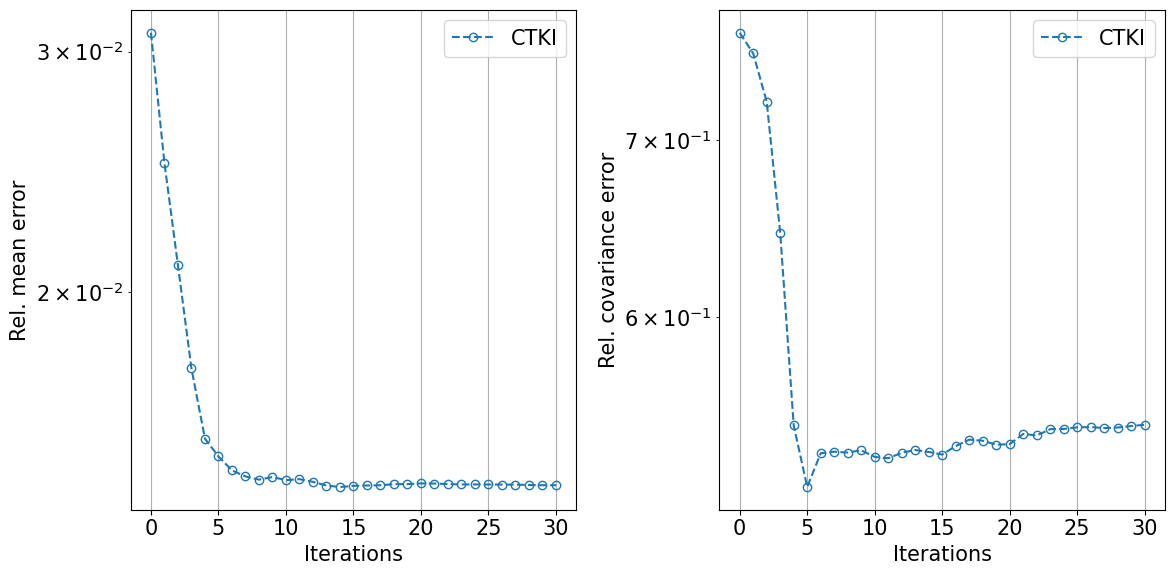

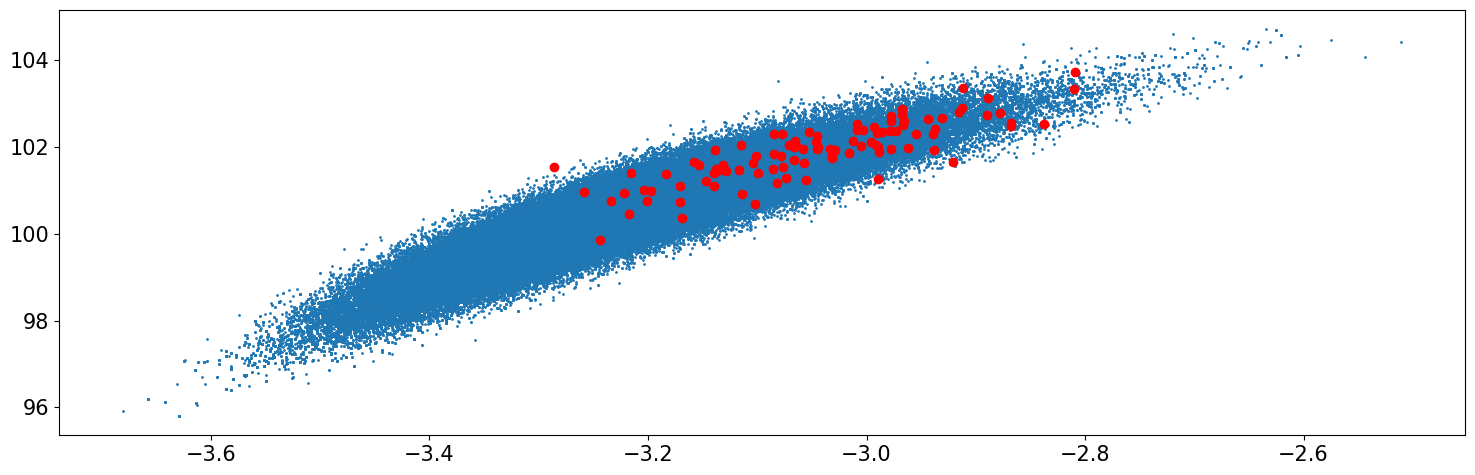

┌ Info: start Ellitic_Posterior_Plot
└ @ Main In[48]:3


In [49]:
problem_type = "under-determined"
μ0 = [0.0, 100.0]
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
Nt, N_ens = 30, 100
Ellitic_Posterior_Plot(problem_type, μ0, Σ0, Nt, N_ens)

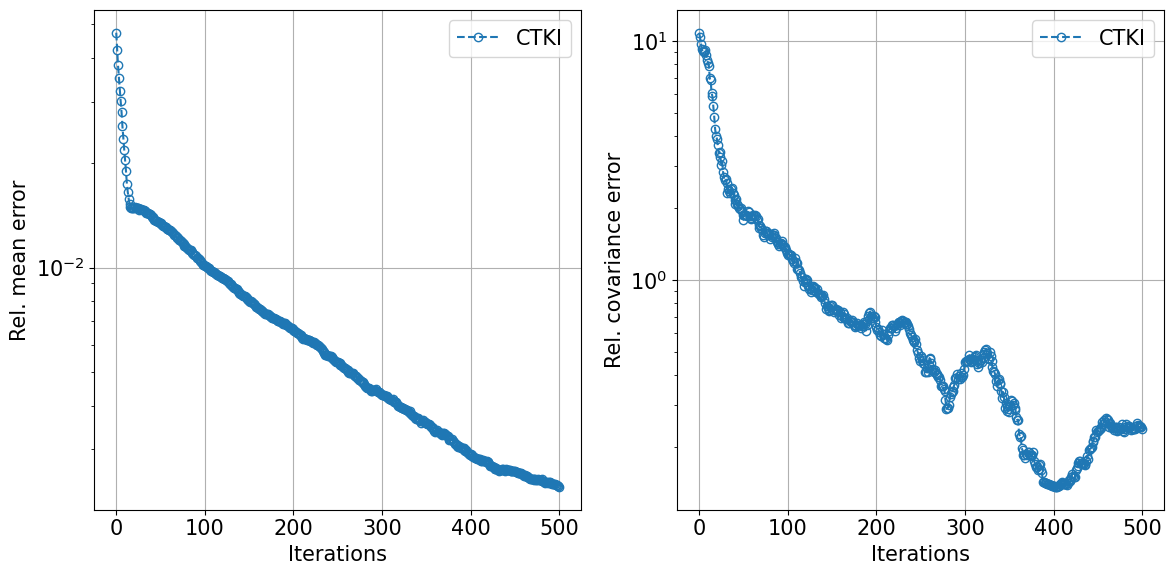

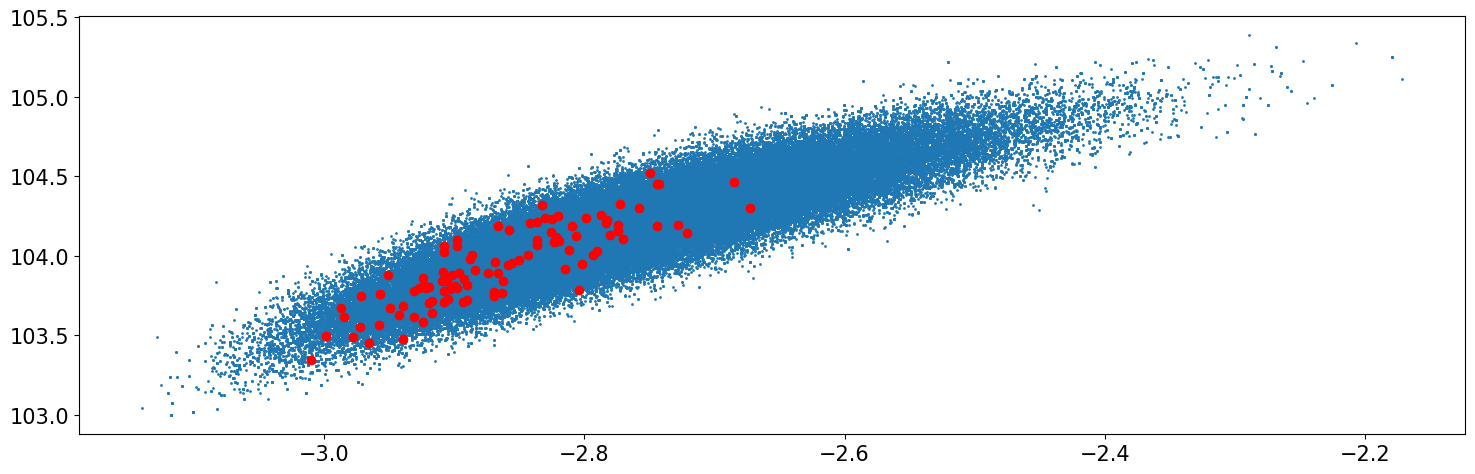

┌ Info: start Ellitic_Posterior_Plot
└ @ Main In[48]:3


In [52]:
problem_type = "well-determined"
μ0 = [0.0, 100.0]
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
Nt, N_ens = 500, 100
Ellitic_Posterior_Plot(problem_type, μ0, Σ0, Nt, N_ens)